In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
pi = 3.1415926535


rcParams = {}
font_size = 20
rcParams["text.usetex"] = True
rcParams["font.family"] = "Times New Roman"
rcParams["font.serif"] = "Times New Roman"
rcParams["font.monospace"] = "Times New Roman"
rcParams["font.size"] = font_size
rcParams["axes.labelsize"] = font_size + 5
rcParams["axes.labelweight"] = "bold"
rcParams["axes.titlesize"] = font_size
rcParams["xtick.labelsize"] = font_size
rcParams["ytick.labelsize"] = font_size
rcParams["legend.fontsize"] = font_size
rcParams["figure.titlesize"] = font_size

ticks_size = 2
rcParams["xtick.direction"] = "in"
rcParams["xtick.minor.visible"] = True
rcParams["xtick.top"] = True   # draw ticks on the top side
rcParams["ytick.direction"] = "in"
rcParams["ytick.minor.visible"] = True
rcParams["ytick.right"] = True   # draw ticks on the top side
rcParams["xtick.major.size"] = 2*ticks_size
rcParams["xtick.minor.size"] = ticks_size
rcParams["ytick.major.size"] = 2*ticks_size
rcParams["ytick.minor.size"] = ticks_size
ticks_width_value = 1
rcParams["axes.linewidth"] = ticks_width_value
rcParams["xtick.major.width"] = ticks_width_value
rcParams["xtick.minor.width"] = ticks_width_value
rcParams["ytick.major.width"] = ticks_width_value
rcParams["ytick.minor.width"] = ticks_width_value

rcParams["legend.borderpad"] = 0.5
rcParams["legend.frameon"] = False
rcParams["legend.handletextpad"] = 0.3
rcParams["legend.handlelength"] = 1.7
rcParams["lines.linewidth"] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10] + ['indigo'])
# plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
plt.rcParams.update(rcParams)
del rcParams

## Funcs

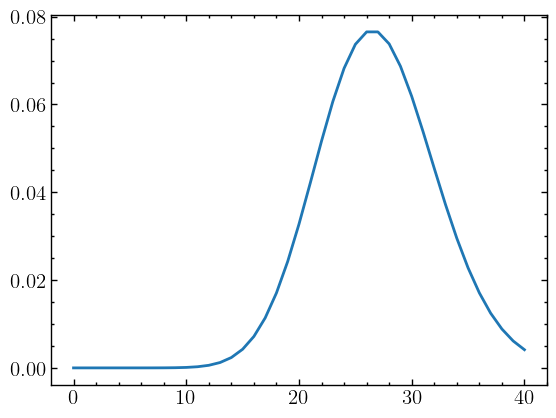

In [26]:
def poisson_distr(x, l):
    res = []
    for n in x:
        res += [l**(n) * np.exp(-l) / np.math.gamma(n+1)]
    return np.array(res) 

def count_within_limits(coords, hmin, hmax, rmin, rmax, phimin, phimax, thetamin, thetamax):
    count = 0
    for e in coords:
        he, re, te, pe = e
        if hmin < he <= hmax and \
           rmin < re <= rmax and \
           phimin < pe <= phimax and \
           thetamin < te <= thetamax:
            count += 1
    return count

def sample_V_hwise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts_hlike = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    hs = [h/n*i + hmin for i in range(0, int(n))]
    for _ in range(int(n-1)):
        counts_hlike += [count_within_limits(coords,
                                            hs[_], hs[_+1],
                                            r, R,
                                            0, 2*np.pi,
                                            0, np.pi)]
    return counts_hlike

def sample_V_rwise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    rds = [(R**d - r**d)/n*i + r**d for i in range(0, int(n))]
    for _ in range(int(n-1)):
        counts += [count_within_limits(coords,
                                        hmin, hmax,
                                        rds[_]**(1/d), rds[_+1]**(1/d),
                                        0, 2*np.pi,
                                        0, np.pi)]
    return counts

def sample_V_phiwise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    phis = [(2*np.pi)/n*i for i in range(0, int(n))]
    for _ in range(int(n-1)):
        counts += [count_within_limits(coords,
                                        hmin, hmax,
                                        r, R,
                                        phis[_], phis[_+1],
                                        0, np.pi)]
    return counts

def sample_V_thetawise(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    counts = []
    coeff = [0, 1, 1, 4/3][d]
    h = hmax - hmin
    Vall = h * pi * (R**d - r**d) * coeff
    n = Vall / V
    coss = [2/n*i -1 for i in range(0, int(n))]
    for _ in range(int(n-1)):
        counts += [count_within_limits(coords,
                                        hmin, hmax,
                                        r, R,
                                        0, 2*np.pi,
                                        np.arccos(coss[_+1]), np.arccos(coss[_])
                )]
    return counts

def sample_V(V, coords, R=1, r=0, hmin=0, hmax=10, d=3):
    ps = [V, coords, R, r, hmin, hmax, d]
    counts_h = sample_V_hwise(*ps)
    counts_r = sample_V_rwise(*ps)
    counts_p = sample_V_phiwise(*ps)
    counts_t = sample_V_thetawise(*ps)
    #print(sum(counts_h), sum(counts_r), sum(counts_r), sum(counts_p))
    return counts_h, counts_r, counts_p, counts_t

def plot_counts(counts, smallV, V, rho, mult=1):
    nrows = len(counts)
    rc = 4; c = 4; r = 1*nrows
    figsize = (c * 3, r * 2)
    nmax = max(max([max(c) for c in counts]))
    plt.figure(figsize = figsize, tight_layout = True)
    plt.suptitle( "Testing Poisson Distribution" )
    for nr in range(nrows):
        for i in range(4):
            plt.subplot(r, c, nr*4 + i + 1)
            if not nr:
                plt.gca().set_title(f'Sampling {["h","r","phi","theta"][i]}-wise')
            data = counts[nr][i]
            #x = np.array([_ for _ in range(int(max(data))+1)])
            # y, binEdges = np.histogram(data, bins=x)
            # bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
            x = np.arange(0, max(data)+1, dtype=int)
            y = [data.count(_) for _ in x]
            menStd     = np.sqrt(y)
            plt.bar(x, y, width = 0.6, yerr=menStd)
            xplt = np.linspace(0, x[-1], 200)
            plt.plot(xplt, mult*V[nr]/smallV[nr]*poisson_distr(xplt, smallV[nr]*rho[nr]), color="red")
            plt.xlim(0, nmax)
    plt.show()

def plot_counts_for_paper(counts, smallV, V, rho, mult=1):
    nrows = len(counts)
    rc = 4; c = 4; r = 1*nrows
    figsize = (c * 3, r * 2)
    nmax = max(max([max(c) for c in counts]))
    plt.figure(figsize = figsize, tight_layout = True)
    for nr in range(nrows):
        for i in range(4):
            plt.subplot(r, c, nr*4 + i + 1)
            data = counts[nr][i]
            x = np.arange(0, max(data)+1)
            y = [data.count(_) for _ in x]
            menStd     = np.sqrt(y)
            plt.bar(x, y, width = 0.6, yerr=menStd, label = "Simulation")
            xplt = np.linspace(0, x[-1], 200)
            plt.plot(xplt, mult*V[nr]/smallV[nr]*poisson_distr(xplt, smallV[nr]*rho[nr]), 
                     color="red", label="Poisson")
            plt.xlim(0, nmax+1)
            plt.xticks(np.arange(0, nmax, 10), labels = np.arange(0, nmax, 10))
            if nr == nrows-1:
                plt.xlabel("\#Points per Region")
            if i == 0:
                plt.ylabel("\#Regions")
            if i==0 and nr == 0:
                plt.legend()
    plt.savefig("../../figures/testing_comp_framework/Poisson_distr.png")
    plt.savefig("../../figures/testing_comp_framework/Poisson_distr.pdf")
    plt.show()

plt.figure()
x = [i for i in range(41)]
plt.plot(x, poisson_distr(x, 27))

In [3]:
def get_causet_attrs (lambdasfile_ext):
    """

    Parameters
    ----------
    - lambdasfile_ext : str
        Name of file from which import info
    
    Returns
    ---------
    - size : int (#0)

    - dim : int (#1)

    - shapename : str (#2)

    - spacetimename : str (#3)

    - coords : list<list<float>> (#4)

    - fut_links : list<list<int>> (#5)
        Note, some are empty

    - r_S : float (#6)
    
    - molecules : list<list<int>> (#7) /not all files have that,
    so might return empty list if molecules are not saved.

    - distribution : list<list<int>> (#8) /not implemented anymore,
    should return empty list
    """
    with open(lambdasfile_ext, 'r') as fl: 
            f = fl.readlines() 

            storage_option = str(f[0].split(",")[1])
            size           = int(f[1].split(",")[1])
            dim            = int(f[2].split(",")[1])
            shapename      = str(f[3].split(",")[1])
            spacetimename  = str(f[4].split(",")[1])
            if dim > 4:
                raise AttributeError(f"Dim is {dim}: too big!!!")

            distribution = []
            mols = []
            coords = []
            r_S = 0

            #start reading file from last line
            go = -1
            while go < 0:
                row = f[go].split(",")
                key = row[0]

                if key == "":
                    go -= 1

                elif key[0:6] == "Lambda":
                    mols.append([])
                    for label in row[1:]:
                        if label != "" and label != "\n":
                            mols[-1].append(int(label))
                    go -= 1
                elif key[0:7] == "NLambda":
                    distribution.append([int(key[-1]), int(row[1])])
                    go -= 1
                
                elif key[0:3] == "HRV":
                    mols.append([])
                    for label in row[1:]:
                        if label != "" and label != "\n":
                            mols[-1].append(int(label))
                    go =- 1
                elif key[0:4] == "NHRV":
                    if key[-1] == "n":
                        distribution.append([0, int(row[1])])
                    else: #key[-1] == "e":
                        distribution.append([1, int(row[1])])
                    go -= 1

                elif "r_S" in key:
                    r_S = float(row[1])
                    go -= 1

                elif "Coordinates" in key:
                    break
                else: #the coordinates#
                    coords.insert(0, [])
                    for i in range(dim):
                        coords[0].append(float(row[i]))
                    go -= 1
        
            if storage_option == "cmatrix" or storage_option == "cmatrix\n":
                cmatrix = []
                for i in range(6, 6+size):
                    cmatrix.append(f[i].split(","))
                cmatrix = np.array(cmatrix, dtype = 'int')
                cmatrix2 = np.matmul(cmatrix, cmatrix)
                for i in range(size):
                    fut_links.append[[]]
                    for j in range(size):
                        if (cmatrix[i,j] and cmatrix2[i,j]==0):
                            fut_links[i].append[j]
            else:
                lines= [[v for v in line.split(",")] for line in open(lambdasfile_ext)]
                fut_links = [[int(v) for v in line if (v != "\n" and v != "")] 
                                for line in lines[6+3*size+3:6+4*size+3]]

    return [size,           #1
            dim,            #2
            shapename,      #3
            spacetimename,  #4

            coords,         #5
            fut_links,      #6
            r_S,            #7

            mols,           #8
            distribution]   #9

## For the neat plot

In [ ]:
rcParams = {}
font_size = 15
rcParams["text.usetex"] = True
rcParams["font.family"] = "Times New Roman"
rcParams["font.serif"] = "Times New Roman"
rcParams["font.monospace"] = "Times New Roman"
rcParams["font.size"] = font_size
rcParams["axes.labelsize"] = font_size + 2
rcParams["axes.labelweight"] = "bold"
rcParams["axes.titlesize"] = font_size
rcParams["xtick.labelsize"] = font_size
rcParams["ytick.labelsize"] = font_size
rcParams["legend.fontsize"] = font_size - 3
rcParams["figure.titlesize"] = font_size

ticks_size = 2
rcParams["xtick.direction"] = "in"
rcParams["xtick.minor.visible"] = True
rcParams["xtick.top"] = True   # draw ticks on the top side
rcParams["ytick.direction"] = "in"
rcParams["ytick.minor.visible"] = True
rcParams["ytick.right"] = True   # draw ticks on the top side
rcParams["xtick.major.size"] = 2*ticks_size
rcParams["xtick.minor.size"] = ticks_size
rcParams["ytick.major.size"] = 2*ticks_size
rcParams["ytick.minor.size"] = ticks_size
ticks_width_value = 1
rcParams["axes.linewidth"] = ticks_width_value
rcParams["xtick.major.width"] = ticks_width_value
rcParams["xtick.minor.width"] = ticks_width_value
rcParams["ytick.major.width"] = ticks_width_value
rcParams["ytick.minor.width"] = ticks_width_value

rcParams["legend.borderpad"] = 0.1
rcParams["legend.frameon"] = False
rcParams["legend.handletextpad"] = 0.2
rcParams["legend.handlelength"] = 0.6
rcParams["lines.linewidth"] = 2
# plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
plt.rcParams.update(rcParams)
del rcParams

mult = 100

for d0 in [800]:
    print(d0)
    card = 10000
    R = 4.00
    h = 0.90
    r = R*h
    hmin = -0.25
    hmax = 0.25
    all_counts2 = [ [], [], [], []]
    for i in tqdm(range(0, mult)):
        filename = f"../../data/test_poiss/4D_N{card}_redge{R:.2f}_h{h:.2f}_c{i}.txt"
        try:
            res = get_causet_attrs(filename)
        except FileNotFoundError:
            break
        res = get_causet_attrs(filename)
        coords = res[4]
        hmin = min(np.array(coords)[:,0])
        hmax = max(np.array(coords)[:,0])
        height = hmax-hmin
        V2 = height * 4/3 * 3.1415926535 * (R*R*R-r*r*r)
        rho2 = card/V2
        #d0 = 625
        smallV2 = V2/d0
        while smallV2/V2*card < 10:
            d0 -= 10
            smallV2 = V2/d0 
        counts2 = sample_V(smallV2, coords, R, r, hmin, hmax, 3)
        for dim in range(len(all_counts2)):
            all_counts2[dim] += counts2[dim]

    card = 10000
    R = 4.00
    h = 0.00
    r = R*h
    hmin = -0.25
    hmax = 0.25
    all_counts1 = [ [], [], [], []]
    for i in tqdm(range(0, mult)):
        filename = f"../../data/test_poiss/4D_N{card}_redge{R:.2f}_h{h:.2f}_c{i}.txt"
        try:
            res = get_causet_attrs(filename)
        except FileNotFoundError:
            break
        coords = res[4]
        hmin = min(np.array(coords)[:,0])
        hmax = max(np.array(coords)[:,0])
        height = hmax-hmin
        V1 = height * 4/3 * 3.1415926535 * (R*R*R-r*r*r)
        rho1 = card/V1
        #d0 = 625
        smallV1 = V1/d0
        while smallV1/V1*card < 10:
            d0 -= 10
            smallV1 = V1/d0
        counts1 = sample_V(smallV1, coords, R, r, hmin, hmax, 3)
        for dim in range(len(all_counts1)):
            all_counts1[dim] += counts1[dim]

    plot_counts_for_paper([all_counts1, all_counts2], [smallV1, smallV2], [V1, V2], [rho1, rho2], mult=mult)

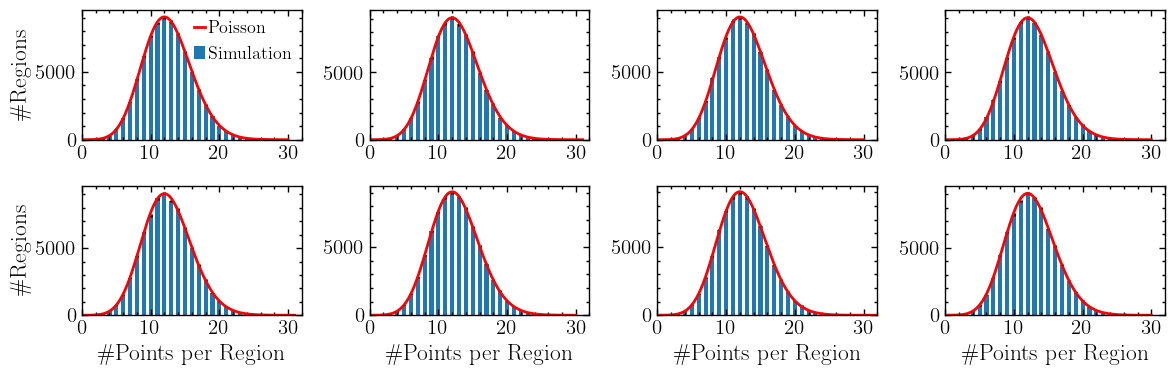

In [27]:
plt.rcParams["legend.fontsize"] = font_size - 2
plot_counts_for_paper([all_counts1, all_counts2], [smallV1, smallV2], [V1, V2], [rho1, rho2], mult=mult)

## Others